# Auswertung Gemeinderat
Stand: 06.04.2021

In [80]:
import pandas as pd
import numpy as np

In [81]:
df = pd.read_csv('../data/Gemeinde_Exekutive - daten.csv')

# Do some stuff...

## Check Gemeinde without chair

In [82]:
df_t = df.fillna("")
df_t = pd.pivot_table(df_t, index='Gemeinde', columns='Funktion', values='Name', aggfunc='count')
df_t[pd.isna(df_t['chair'])]

Funktion,,chair,school
Gemeinde,,,


## Data transformation...

In [83]:
df.loc[df.partei_nicht_zugeordnet == 1, 'partei_nicht_zugeordnet'] = True
df['partei_nicht_zugeordnet'] = df['partei_nicht_zugeordnet'].fillna(False)

df[df.jahrgang_nicht_zugeordnet == 1] = True
df['jahrgang_nicht_zugeordnet'] = df['jahrgang_nicht_zugeordnet'].fillna(False)

# Alter berechnen
df['Alter'] = 2021 - df['Jahrgang']

print("Jahrgänge nicht zugeordnet: %s" % len(df[df.jahrgang_nicht_zugeordnet == True]))
print("Partei nicht zugeordnet: %s" % len(df[df.partei_nicht_zugeordnet == True]))
print("Keine Jahrgänge: %s" % len(df[df.Jahrgang.isna()]))

Jahrgänge nicht zugeordnet: 0
Partei nicht zugeordnet: 9
Keine Jahrgänge: 18


## Clean Party

In [117]:
# Add partei_clean
def transform_partei(p):

    if type(p) == str:
        p = p.lower()
    
    if p == 'die mitte': p = 'cvp'
        
    if p in ['parteilos', 'fdp', 'evp', 'svp', 'sp', 'cvp', 'glp', 'grüne', 'bdp', 'al', 'edu']:
        return p
    return 'verschiedene'

df['partei_c'] = df['Partei'].apply(transform_partei)

# Alles über Parteien

## Die grössten Parteien

In [118]:
grPartei = df.groupby('partei_c').agg({'Gemeinde': 'count'}).sort_values('Gemeinde', ascending=False)
grPartei['prozent'] = round(100 / df['Gemeinde'].count() * grPartei.Gemeinde, 1)

<AxesSubplot:xlabel='partei_c'>

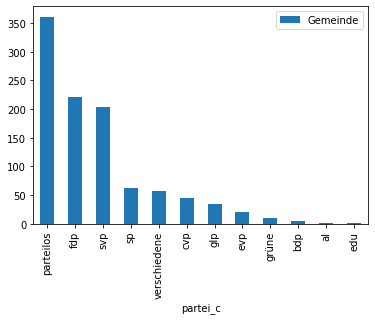

In [119]:
grPartei.plot.bar(y = 'Gemeinde')

### In Prozent

In [120]:
grPartei

,Gemeinde,prozent
partei_c,,
parteilos,361,35.5
fdp,220,21.6
svp,203,20.0
sp,62,6.1
verschiedene,57,5.6
cvp,44,4.3
glp,34,3.3
evp,20,2.0
grüne,10,1.0


## Die parteilosesten Gemeinden

In [121]:
g = df.copy().groupby(['Gemeinde', 'partei_c']).agg({'Name': 'count'}).reset_index()
g = g.sort_values(['Gemeinde', 'Name'], ascending=[True, False])
g = g.drop_duplicates(['Gemeinde'])
g = g[g.partei_c == 'parteilos'].sort_values('Name', ascending=False)
g = g.rename(columns={'Name': 'Anzahl Parteilose'})
g.head(10)

,Gemeinde,partei_c,Anzahl Parteilose
361,Rifferswil,parteilos,7
309,Obfelden,parteilos,6
262,Mettmenstetten,parteilos,6
99,Dättlikon,parteilos,6
382,Schleinikon,parteilos,5
301,Oberglatt,parteilos,5
288,Niederweningen,parteilos,5
381,Schlatt (ZH),parteilos,5
120,Ellikon an der Thur,parteilos,5
392,Schöfflisdorf,parteilos,5


## Die politisch diversesten Gemeinden

In [101]:
g = df.groupby(['Gemeinde', 'partei_c']).count().reset_index()
g = g.groupby('Gemeinde').agg({'partei_c': 'count'})
g = g.sort_values('partei_c', ascending=False).reset_index()
g = g.rename(columns={'partei_c': 'anzahl parteien'})
g.head(10)

,Gemeinde,anzahl parteien
0,Opfikon,6
1,Wallisellen,6
2,Langnau am Albis,6
3,Urdorf,6
4,Schlieren,6
5,Horgen,6
6,Richterswil,6
7,Dietikon,6
8,Adliswil,6
9,Kloten,6


## Welche Partei stellt das Präsidium?

In [102]:
df[df.Funktion == 'chair'].groupby('partei_c').agg({'Gemeinde': 'count'}).sort_values('Gemeinde', ascending=False)

,Gemeinde
partei_c,
parteilos,54
fdp,44
svp,35
verschiedene,10
sp,7
cvp,5
evp,4
glp,3


# Alles über die Geschlechter

## Geschlechterverhältnis

In [105]:
grGender = df.groupby('Geschlecht').agg({'Name': 'count'})
grGender['prozent'] = round(100 / len(df) * grGender.Name, 1)
grGender

,Name,prozent
Geschlecht,,
m,736,72.4
w,280,27.5


## Der Durchschnitts-Gemeinderat (m/w) ist...

In [106]:
df_alter = df[df.Alter.notna() & df.jahrgang_nicht_zugeordnet.notna()]
print("Männlich")
print("%s Jahre alt" % round(df_alter.Alter.mean()))
print("parteilos")


Männlich
56 Jahre alt
parteilos


## Die Durchschnitts-Gemeinderätin ist...

In [107]:
df_alter = df[df.Alter.notna() & df.jahrgang_nicht_zugeordnet.notna()]
print("%s Jahre alt" % round(df_alter[df_alter.Geschlecht == 'w'].Alter.mean()))
print("parteilos")

55 Jahre alt
parteilos


## Der Durchschnitts-Gemeinderat (m) ist...

In [108]:
df_alter = df[df.Alter.notna() & df.jahrgang_nicht_zugeordnet.notna()]
print("%s Jahre alt" % round(df_alter[df_alter.Geschlecht == 'm'].Alter.mean()))
print("parteilos")

56 Jahre alt
parteilos


## Gendereinseitige Gemeinderäte

In [110]:
df_g = pd.pivot_table(df, 'Name', 'Gemeinde', columns='Geschlecht', aggfunc='count')
df_g['w'] = df_g['w'].fillna(0)
df_g['total'] = df_g.m + df_g.w
df_g['m%'] = round(100 / df_g.total * df_g.m)
df_g['w%'] = round(100 / df_g.total * df_g.w)
df_g[df_g['m%'] == 100]

Geschlecht,m,w,total,m%,w%
Gemeinde,,,,,
Dachsen,5.0,0.0,5.0,100.0,0.0
Dietikon,7.0,0.0,7.0,100.0,0.0
Dägerlen,5.0,0.0,5.0,100.0,0.0
Ellikon an der Thur,5.0,0.0,5.0,100.0,0.0
Humlikon,5.0,0.0,5.0,100.0,0.0
Oetwil am See,7.0,0.0,7.0,100.0,0.0
Regensdorf,7.0,0.0,7.0,100.0,0.0
Rheinau,5.0,0.0,5.0,100.0,0.0
Wasterkingen,5.0,0.0,5.0,100.0,0.0


### Die weiblichste Gemeinde

In [122]:
df_g = df_g.sort_values('w%', ascending=False)
df_g[df_g['w%'] >= 50]

Geschlecht,m,w,total,m%,w%
Gemeinde,,,,,
Aeugst am Albis,3.0,5.0,8.0,38.0,62.0
Regensberg,2.0,3.0,5.0,40.0,60.0
Boppelsen,2.0,3.0,5.0,40.0,60.0
Kappel am Albis,2.0,3.0,5.0,40.0,60.0
Wiesendangen,3.0,4.0,7.0,43.0,57.0
Kilchberg (ZH),3.0,4.0,7.0,43.0,57.0
Marthalen,3.0,4.0,7.0,43.0,57.0
Uster,3.0,4.0,7.0,43.0,57.0
Rümlang,3.0,4.0,7.0,43.0,57.0


## Gemeinderäte mit nur Männer, nur Frauen

In [95]:
df_g = pd.pivot_table(df, 'Name', 'Gemeinde', columns='Geschlecht', aggfunc='count')
df_g['w'] = df_g['w'].fillna(0)
df_g['total'] = df_g.m + df_g.w
df_g['m%'] = round(100 / df_g.total * df_g.m)
df_g['w%'] = round(100 / df_g.total * df_g.w)

print('Reine Männer-Räte: %s' % len(df_g[df_g['m%'] == 100]))
print('Reine Frauen-Räte: %s' % len(df_g[df_g['w%'] == 100]))

Reine Männer-Räte: 13
Reine Frauen-Räte: 0


## Gemeinderäte mit Mehrheit Frauen/Männer

In [116]:
df_g = pd.pivot_table(df, 'Name', 'Gemeinde', columns='Geschlecht', aggfunc='count')
df_g['w'] = df_g['w'].fillna(0)
df_g['total'] = df_g.m + df_g.w
df_g['m%'] = round(100 / df_g.total * df_g.m)
df_g['w%'] = round(100 / df_g.total * df_g.w)

print("Männer mehr 50 Prozent+: %s" % len(df_g[df_g['m%'] >= 50]))
print("Frauen mehr 50 Prozent+: %s" % len(df_g[df_g['w%'] >= 50]))

Männer mehr 50 Prozent+: 152
Frauen mehr 50 Prozent+: 15


## Das Gemeindepräsidium ('chair') ist...

In [115]:
df_pr = pd.pivot_table(df, index='Funktion', columns='Geschlecht', values='Name', aggfunc='count')
#df_pr = df_pr[df_pr.Funktion == 'chair']
df_pr['m%'] = round(100 / (df_pr['m'] + df_pr['w']) * df_pr['m'])
df_pr['w%'] = round(100 / (df_pr['m'] + df_pr['w']) * df_pr['w'])

df_pr.head()

Geschlecht,m,w,m%,w%
Funktion,,,,
chair,133,29,82.0,18.0
school,3,6,33.0,67.0


# Unterschiede Männer-Frauen-Räte

# Alles übers Alter

## Das jüngste Gremium

In [89]:
df_age = df[df.Jahrgang.notna()].copy()
df_age['Alter'] = pd.to_numeric(df_age['Alter'])

df_age = df_age.groupby('Gemeinde').agg({'Alter': 'mean'})

df_age['Alter'] = round(df_age['Alter'], 1)

df_age.sort_values('Alter', ascending=True).head()

,Alter
Gemeinde,
Thalheim an der Thur,46.5
Fischenthal,47.0
Bäretswil,47.4
Regensberg,47.8
Hüttikon,47.8


## Das älteste Gremium

In [69]:
df_age.sort_values('Alter', ascending=False).head()

,Alter
Gemeinde,
Geroldswil,66.7
Männedorf,64.9
Birmensdorf (ZH),64.3
Nürensdorf,62.0
Niederweningen,62.0


## Die Küken

In [98]:
df.sort_values('Alter').head(10)

,Gemeinde,Name,Jahrgang,Geschlecht,Partei,Funktion,Hinweis,jahrgang_nicht_zugeordnet,partei_nicht_zugeordnet,Gecheckt 2021,Alter,partei_c
899,Oberengstringen,"Leupi, Andreas",1996,m,SVP,NaN,NaN,False,False,x,25,SVP
133,Bonstetten,"Vergés Simon, 1996, Partei: SP",1996,m,SP,NaN,NaN,False,False,x,25,SP
169,Wila,"Gemeinderat Simon Mösch, BDP, Jahrgang 1994",1994,m,BDP,NaN,NaN,False,False,x,27,BDP
493,Wil (ZH),Caspar Briner,1994,m,parteilos,NaN,NaN,False,False,x,27,parteilos
544,Dürnten,Jasmin Aeschbacher\nRessort Schutz + Sicherheit,1993,w,FDV (Freie Demokratische Vereinigung),NaN,NaN,False,False,x,28,verschiedene
388,Eglisau,"Nicolas Wälle, parteilos, Jg. 1992",1992,m,parteilos,NaN,NaN,False,False,x,29,parteilos
392,Dägerlen,Severin Knecht,1991,m,glp,NaN,NaN,False,False,x,30,glp
906,Trüllikon,Manuel Frei 1991 Gemeinderat,1991,m,parteilos,NaN,NaN,False,False,x,30,parteilos
19,Seegräben,Reto Gasser,1989,m,SVP,NaN,NaN,False,False,x,32,SVP
507,Glattfelden,"Michèle Dünki, SP, Jahrgang 1989",1989,w,SP,NaN,NaN,False,False,x,32,SP


## Die Silberrücken

In [101]:
df.sort_values('Alter', ascending=False).head(10)

,Gemeinde,Name,Jahrgang,Geschlecht,Partei,Funktion,Hinweis,jahrgang_nicht_zugeordnet,partei_nicht_zugeordnet,Gecheckt 2021,Alter,partei_c
923,Geroldswil,Veronika Neubauer,1946,w,SVP,NaN,Ein Sitz Vakant,False,False,x,75,SVP
60,Männedorf,André Thouvenin,1946,m,FDP,chair,NaN,False,False,x,75,FDP
125,Neerach,MARKUS ZINK,1947,m,parteilos,chair,NaN,False,False,x,74,parteilos
159,Niederweningen,"Ruth Weber: 72 Jahre, Jg. 1947",1947,w,parteilos,NaN,NaN,False,False,x,74,parteilos
805,Wädenswil,Brupbacher Ernst (Grübi),1947,m,BFPW,NaN,NaN,False,False,x,74,verschiedene
859,Bülach,Dr. Walter Baur SVP 1947,1947,m,SVP,NaN,NaN,False,False,x,74,SVP
315,Unterengstringen,"Wirth, Simon, 1947",1947,m,FDP,chair,NaN,False,False,x,74,FDP
626,Lindau,Peter Reinhard,1947,m,SP,NaN,NaN,False,False,x,74,SP
690,Brütten,"Bosshart, Rudolf",1948,m,FDP,chair,NaN,False,False,x,73,FDP
464,Birmensdorf (ZH),"Hans Rudolf (Ringo) Keller, SVP, 1948",1948,m,SVP,NaN,NaN,False,False,x,73,SVP


## Alter pro Partei

In [346]:
df_a = df[df.Alter.notna() & df.partei_nicht_zugeordnet == False].copy()
df_a['Alter'] = pd.to_numeric(df_a['Alter'])
df_a = df_a.groupby('partei_c').agg({'Alter': 'mean'}).sort_values('Alter', ascending=False)
df_a['Alter'] = round(df_a['Alter'], 1)

df_a

,Alter
partei_c,
al,64.0
cvp,58.4
fdp,57.0
evp,56.8
sp,55.8
svp,55.5
grüne,55.0
parteilos,55.0
verschiedene,54.6


# --- In Arbeit

## Historisch

In [13]:
df_2017 = pd.read_csv('../data/2017_cleaned.csv')

# Remove leer
df_2017 = df_2017[df_2017.GSB17_Teilnahme == 1]

# Add total
df_2017['total'] = df_2017['m'] + df_2017['w']

### Parteilos 2017

In [20]:
print("Parteilos: %s" % df_2017['parteilos'].sum())
print("Prozentual: %s" % round(100 / df_2017['total'].sum() * df_2017['parteilos'].sum()))


Parteilos: 248
Prozentual: 29.0


### Parteilos 2020

In [33]:
print("Parteilos: %s" % df[df.partei_c == 'parteilos']['Gemeinde'].count())
print("Prozent ual: %s" % round(100 / df.groupby('partei_c').count()['Gemeinde'].sum() * df[df.partei_c == 'parteilos']['Gemeinde'].count()))

Parteilos: 353
Prozentual: 35.0


### Gender 2017

In [41]:
print("Frauen %%: %s" % round(100 / df_2017['total'].sum() * df_2017['w'].sum()))

Frauen %: 23.0


### Gender 2020

In [337]:
print("Frauen %%: %s" % round(100 / df.groupby('partei_c').count()['Gemeinde'].sum() * df[df.Geschlecht == 'w']['Gemeinde'].count()))

Frauen %: 28


# QGIS export

## Aggregate different vectors

In [359]:
# Find strongest Party. "Multiple" when no single party is the stronges

df_g = df

df_g = pd.pivot_table(df_g, index='Gemeinde', columns='partei_c', values='Name', aggfunc='count').fillna(0)

def maxparty(row):
    maxi = 0
    maxs = ""
    multiple = False
    for i in df_g.columns:
        if i == 'partei_c': continue
        
        if row[i] == maxi:
            multiple = True
        elif row[i] > maxi:
            maxi = row[i]
            maxs = i
            multiple = False
            
    if multiple:
        return 'multiple'
    else:
        return maxs

df_g['topparty'] = df_g.apply(maxparty, axis=1)

# Add "Has Top Party": single, multi or parteilos
def add_has_topparty(x):
    if x == 'multiple': return 'multiple'
    elif x == 'parteilos': return 'parteilos'
    else: return 'single'

df_g['has_topparty'] = df_g['topparty'].apply(add_has_topparty)

df_export = df_g.reset_index()[['Gemeinde', 'topparty', 'has_topparty']].copy()

# Diese Parteien sind so oft die grösste Partei ihrer Gemeinde
df_g.reset_index().groupby('topparty').agg({'Gemeinde': 'count'}).sort_values('Gemeinde', ascending=False)

,Gemeinde
topparty,
parteilos,62
multiple,46
fdp,26
svp,19
sp,4
verschiedene,4
cvp,1


In [360]:
# Calc Partys percentage
df_g = pd.pivot_table(df, index='Gemeinde', columns='partei_c', values='Name', aggfunc='count').fillna(0)
df_g['total'] = df_g.sum(axis=1)

def calc_percentage(row):
    for i in df_g.columns:
        row[i] = round(100 / row['total'] * row[i], 1)
    return row

df_g = df_g.apply(calc_percentage, axis=1)

# Drop total
df_g.drop(columns='total', inplace=True)

df_export = df_export.merge(df_g.reset_index(), on='Gemeinde', how='left')

In [361]:
# Add m / w

df_g = pd.pivot_table(df, index='Gemeinde', columns='Geschlecht', values='Name', aggfunc='count')

df_g['total'] = df_g.sum(axis=1)
df_g['m'] = round(100 / df_g['total'] * df_g['m'])
df_g['w'] = round(100 / df_g['total'] * df_g['w'])

df_export = df_export.merge(df_g.reset_index()[['Gemeinde', 'm', 'w']], on='Gemeinde', how='left')

In [362]:
# Add age m / w

df_a = df[df.Alter.notna()].copy()
df_a['Alter'] = pd.to_numeric(df_a['Alter'])
df_g = pd.pivot_table(df_a, index='Gemeinde', columns='Geschlecht', values='Alter', aggfunc='mean')

df_g = df_g.apply(lambda x: round(x))

df_g.rename(columns={'m': 'age_m', 'w': 'age_w'}, inplace=True)

df_export = df_export.merge(df_g.reset_index(), on='Gemeinde', how='left')

In [363]:
# Agg General

df_a = df[df.Alter.notna()].copy()
df_a['Alter'] = pd.to_numeric(df_a['Alter'])

df_a = df_a.groupby('Gemeinde').agg({'Alter': 'mean'})

df_a['Alter'] = round(df_a['Alter'])

df_export = df_export.merge(df_a.reset_index(), on='Gemeinde', how='left')

df_export = df_export.set_index('Gemeinde')

## Join per GeoPandas and Export

In [379]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [365]:
gdf = gpd.read_file('../data/Gemeindegrenzen.gpkg', layer='UP_GEMEINDEN_F')

# Join
gdf = gdf.merge(df_export, left_on = 'GEMEINDENAME', right_on='Gemeinde', how='left')

# Export
gdf.to_file('../export/gemeinderaete.gpkg', driver='GPKG')

## Parteilose eher am Rande des Kantons (ländlich)

<AxesSubplot:>

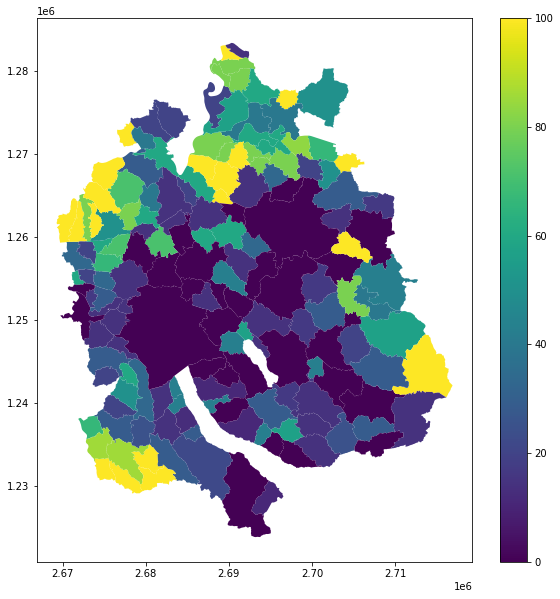

In [331]:
gdf.plot(column='parteilos', legend=True, figsize=(10, 10))

## Welche Partei hat wo die Mehrheit?

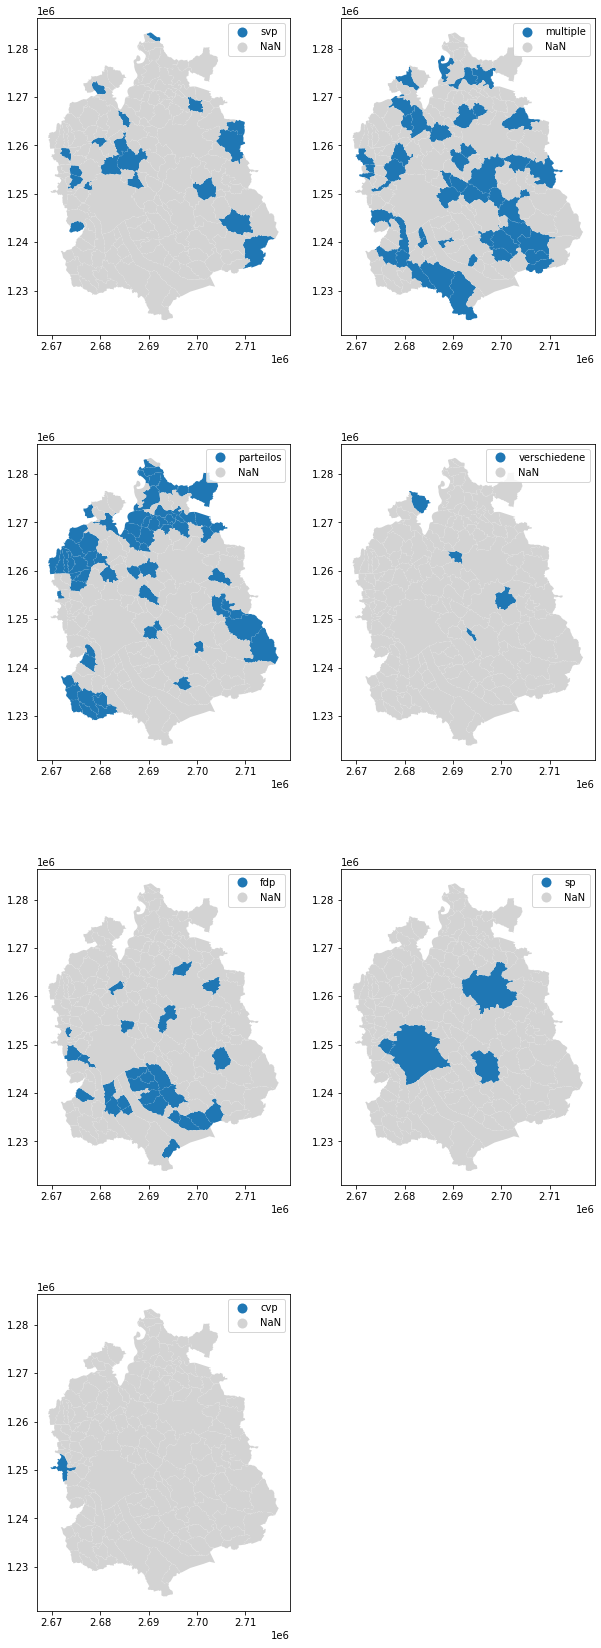

In [458]:
fig = plt.figure(figsize = (10, 30))

#fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

c = 1
for i, party in enumerate(gdf['topparty'].unique()):
    
    if not (type(party) == str): continue
    
    ax1 = fig.add_subplot(4, 2, c)
    gdf['leadingparty'] = gdf.topparty.apply(lambda x: party if x == party else None)
    gdf.plot(ax=ax1, column='leadingparty', missing_kwds={'color': 'lightgrey'}, legend=True)
    c += 1
